In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
submit_path = './'

In [3]:
results = {}
score_sum = 0
score_min = 1

def load_result(model, score):
    results[model] = [pd.read_csv(os.path.join(submit_path, model+'_best.csv'), encoding='utf-8'), score]
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,9))
    fig.tight_layout(pad=2)
    ax1 = results[model][0]['prediction'].hist(ax=ax1)
    ax2 = results[model][0]['prediction'].plot.density(ax=ax2)
    
    global score_sum, score_min
    score_sum += score
    score_min = min(score_min, score)

# Bert

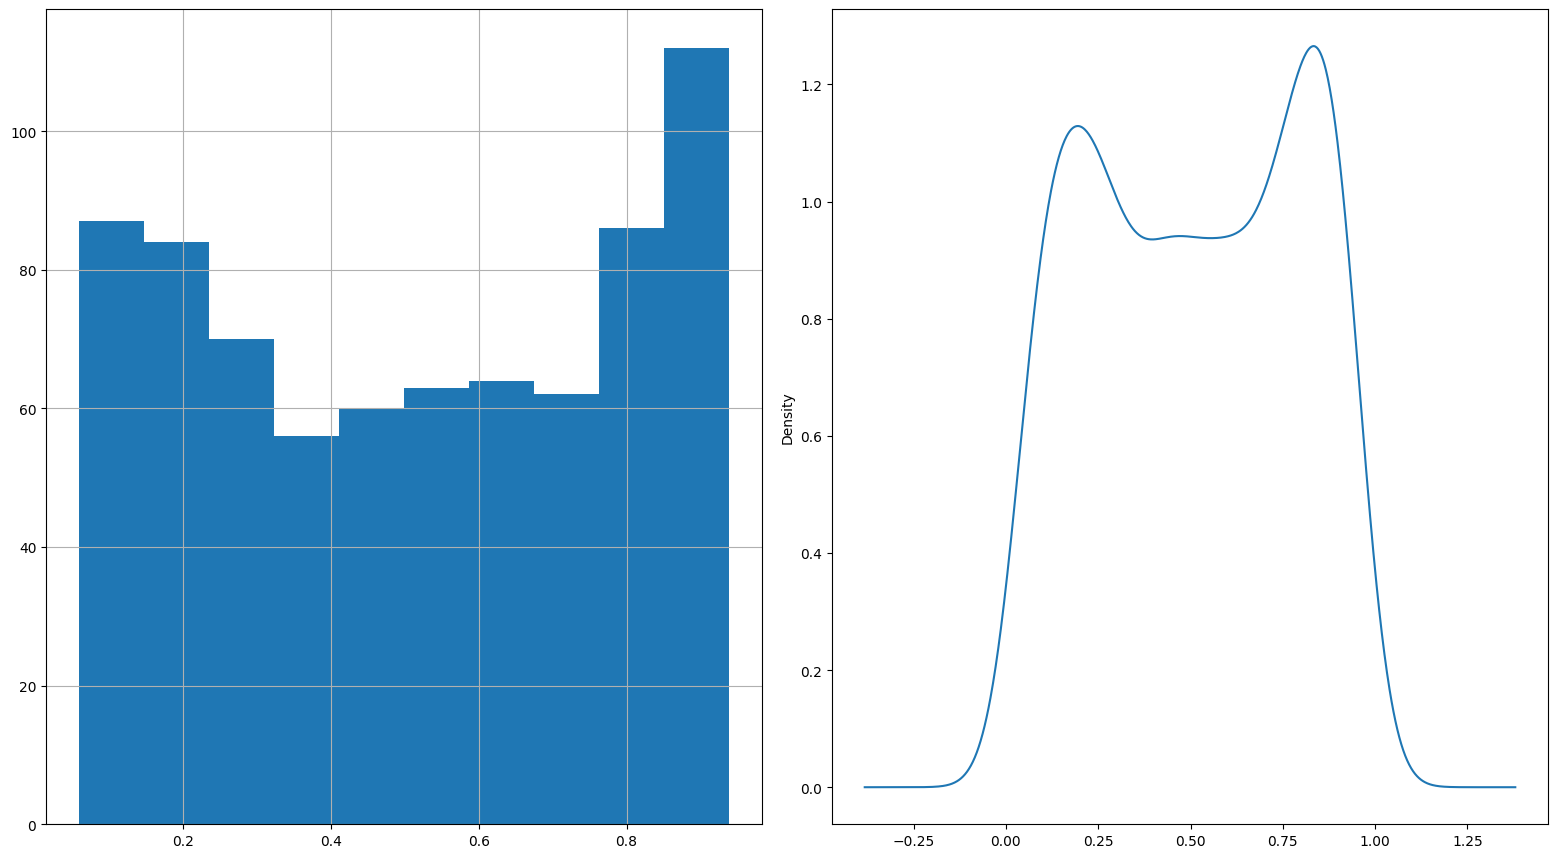

In [4]:
load_result('bert', 0.8093)

# Saint

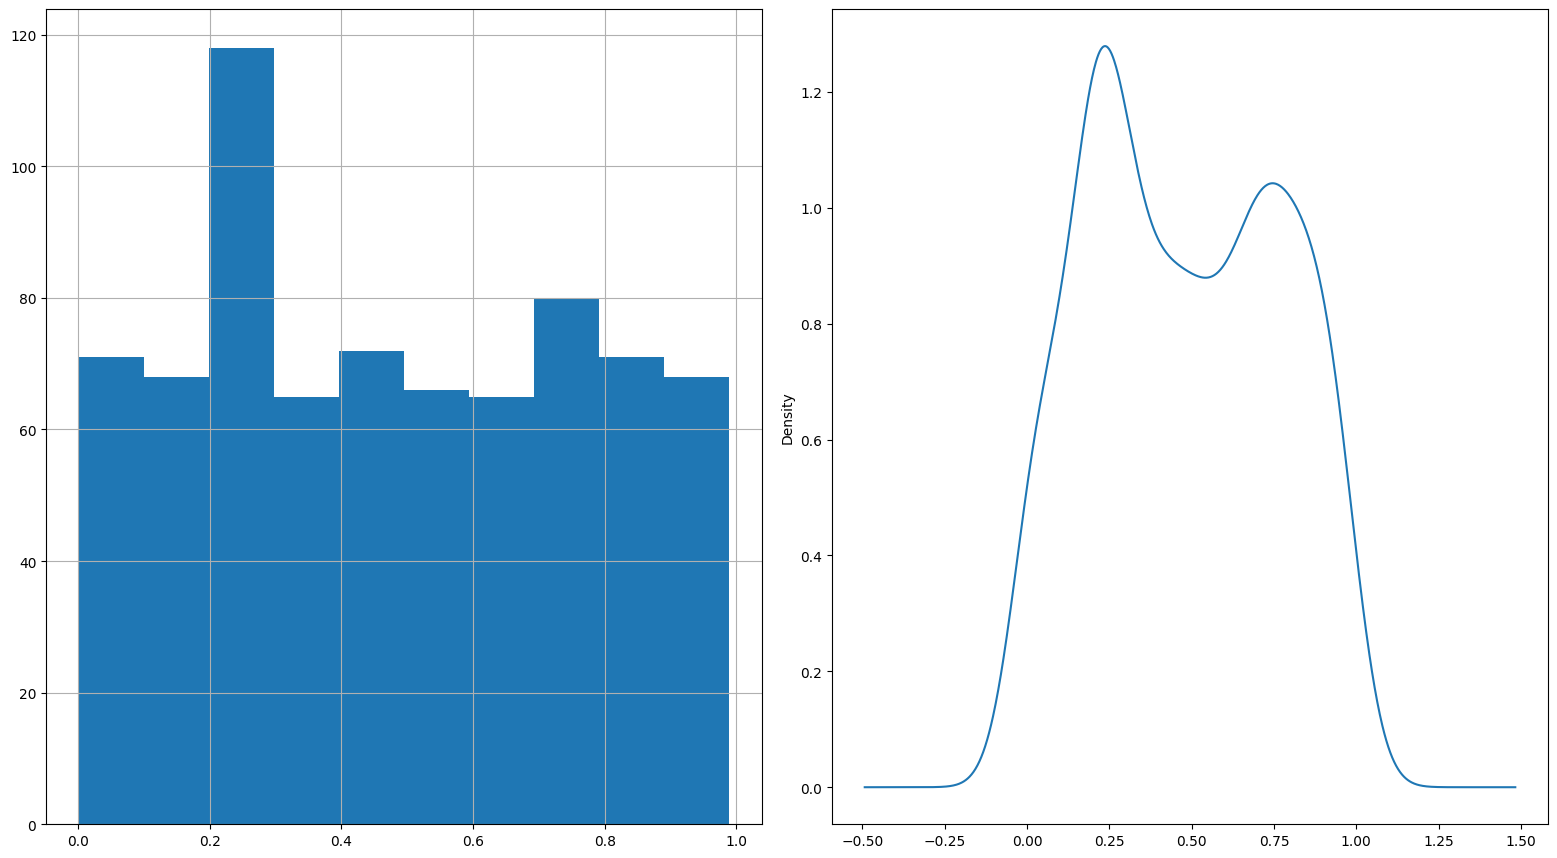

In [5]:
load_result('saint', 0.7997)

# LightGCN

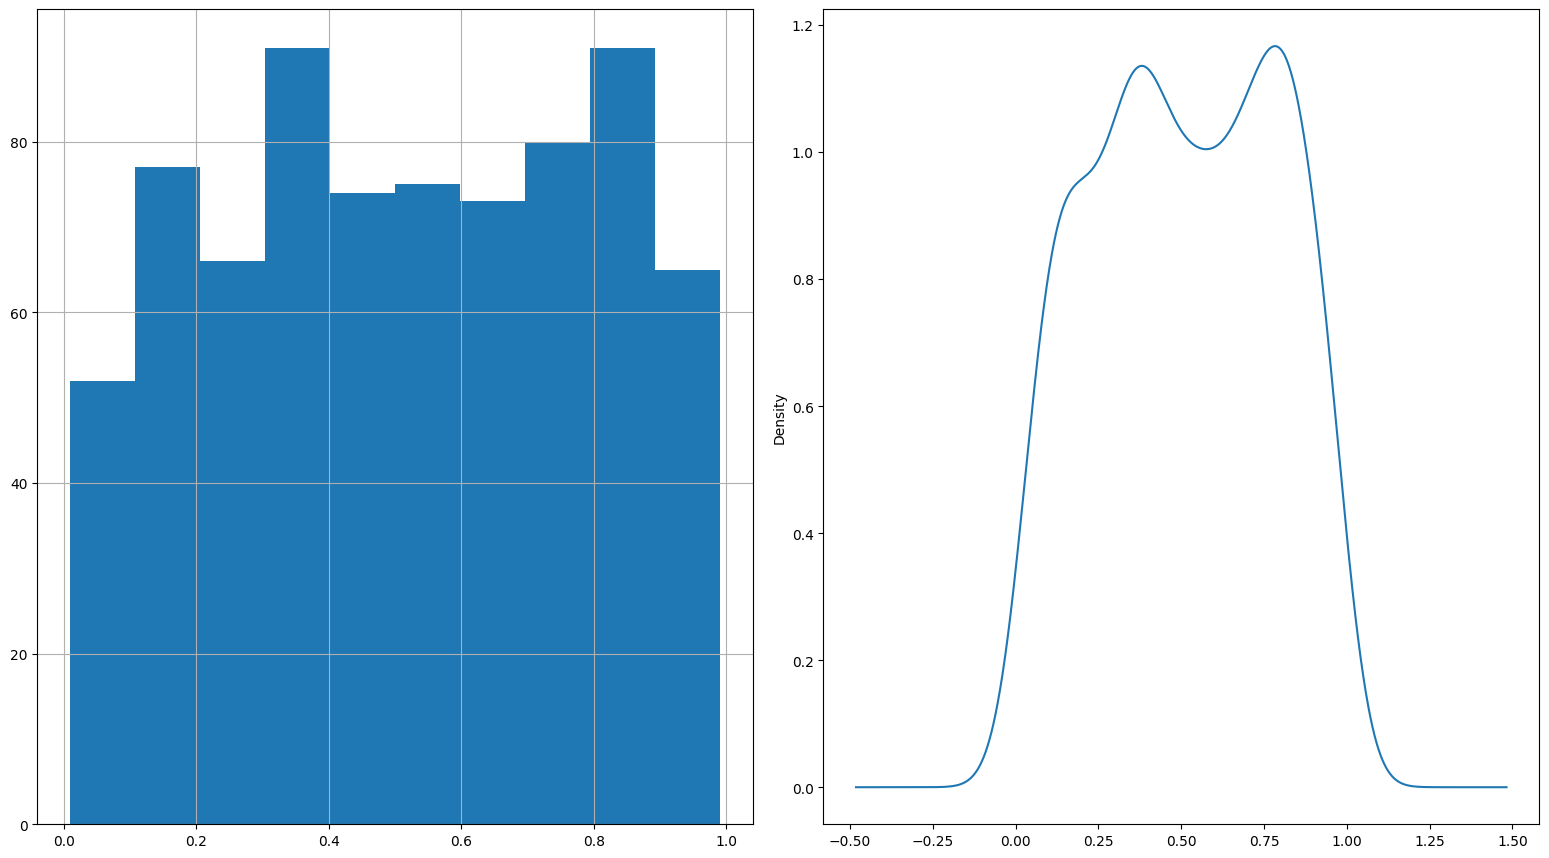

In [6]:
load_result('lightgcn', 0.7934)

# TabNet

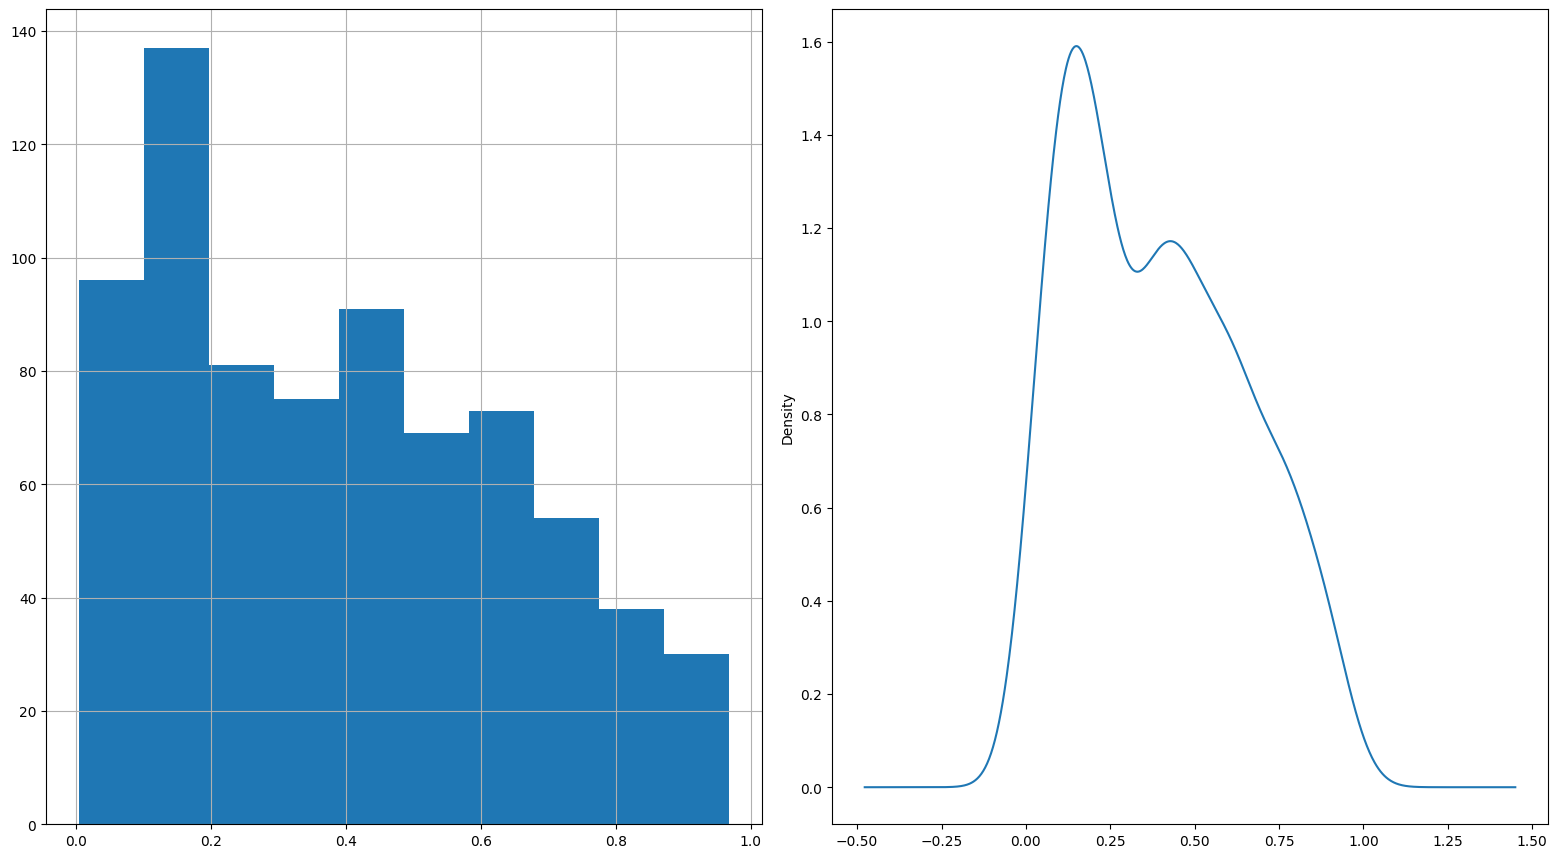

In [7]:
load_result('tabnet', 0.7891)

# 비교

In [8]:
tmp = pd.read_csv(os.path.join(submit_path, 'bert_best.csv'), encoding='utf-8')['id']
for k, v in results.items():
    v[0].columns = ['id', f'{k}_{v[1]}']
    tmp = pd.merge(tmp, v[0], on='id')

In [9]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744 entries, 0 to 743
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               744 non-null    int64  
 1   bert_0.8093      744 non-null    float64
 2   saint_0.7997     744 non-null    float64
 3   lightgcn_0.7934  744 non-null    float64
 4   tabnet_0.7891    744 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 34.9 KB


<AxesSubplot: ylabel='Density'>

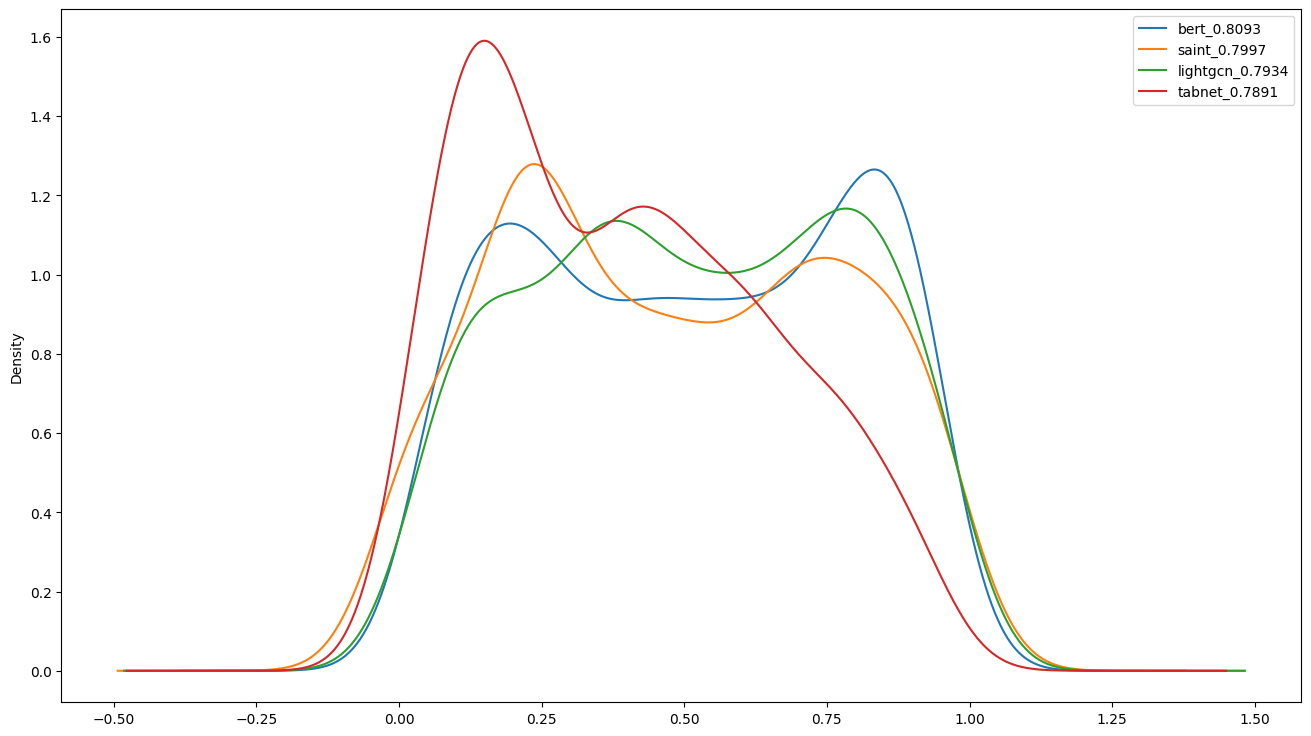

In [10]:
tmp[tmp.columns.values[1:]].plot.density(figsize=(16,9))

# Ensemble

### Sum

In [11]:
sum_ensemble = pd.read_csv(os.path.join(submit_path, 'bert_best.csv'), encoding='utf-8')

In [12]:
sum_ensemble['prediction'] = 0
for r in tmp.columns.values[1:]:
    sum_ensemble['prediction'] += tmp[r] / len(tmp.columns.values[1:])

<AxesSubplot: ylabel='Density'>

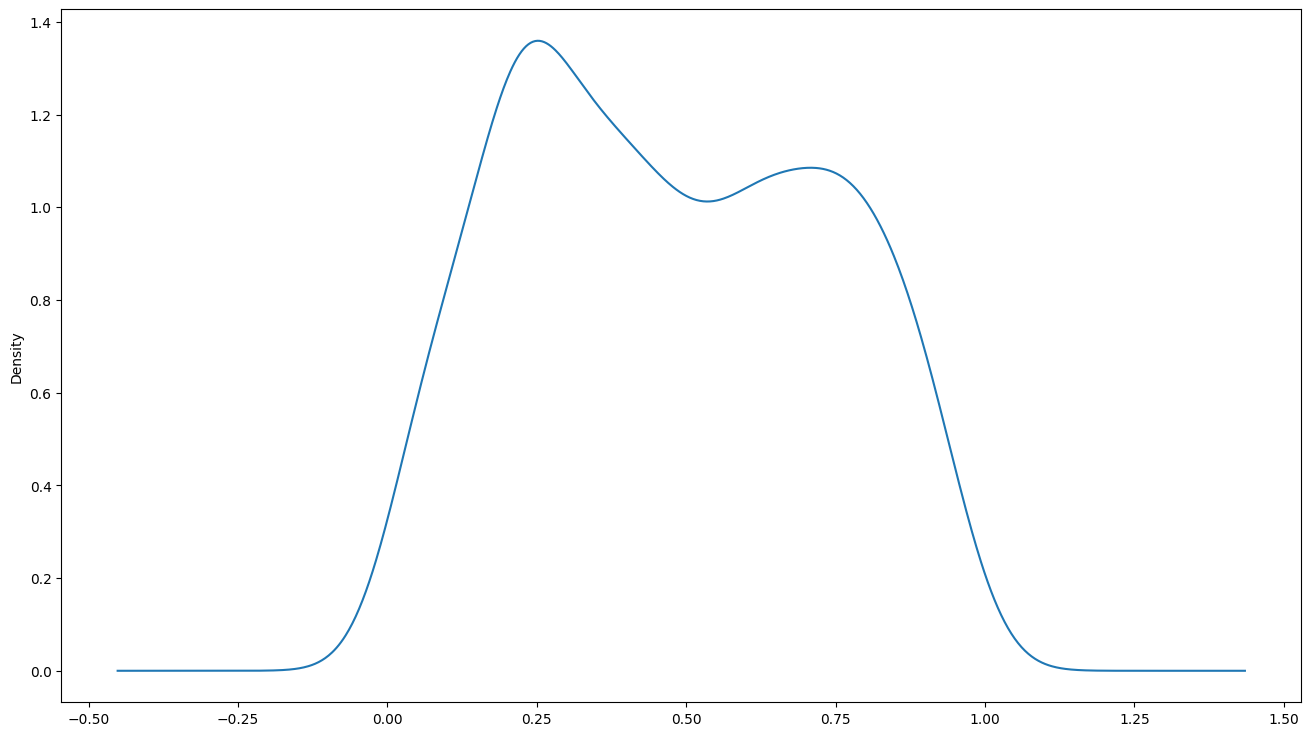

In [13]:
sum_ensemble['prediction'].plot.density(figsize=(16,9))

In [14]:
sum_ensemble.to_csv(os.path.join('ensemble/', 'sum_ensemble.csv'), index_label="id")

### Score Weighted Sum

In [15]:
wsum_ensemble = pd.read_csv(os.path.join(submit_path, 'bert_best.csv'), encoding='utf-8')

In [16]:
threshold = 0.78    # min:0.7891, max: 0.8093
wsum_ensemble['prediction'] = 0
for k,v in results.items():
    wsum_ensemble['prediction'] += v[0][f'{k}_{v[1]}'] * (v[1] - threshold) / (score_sum - threshold*len(results))

<AxesSubplot: ylabel='Density'>

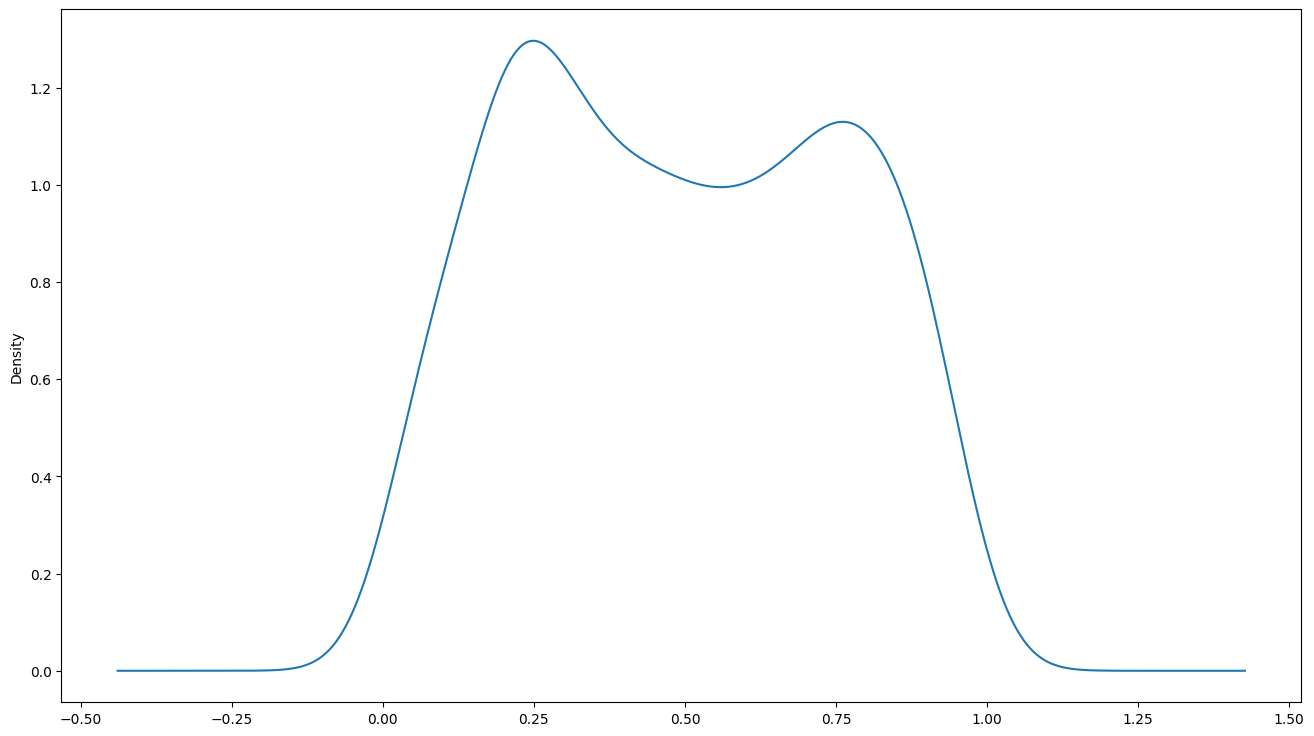

In [17]:
wsum_ensemble['prediction'].plot.density(figsize=(16,9))

In [18]:
wsum_ensemble.to_csv(os.path.join('ensemble/', 'wsum_ensemble.csv'), index_label="id")

### 부분 Scaled Weighted Sum (w/o TabNet) 

In [19]:
wsum_ensemble_wot = pd.read_csv(os.path.join(submit_path, 'bert_best.csv'), encoding='utf-8')

In [20]:
wsum_ensemble_wot['prediction'] = 0
for k,v in results.items():
    wsum_ensemble_wot['prediction'] += v[0][f'{k}_{v[1]}'] * (v[1] - score_min) / (score_sum - score_min*len(results))

<AxesSubplot: ylabel='Density'>

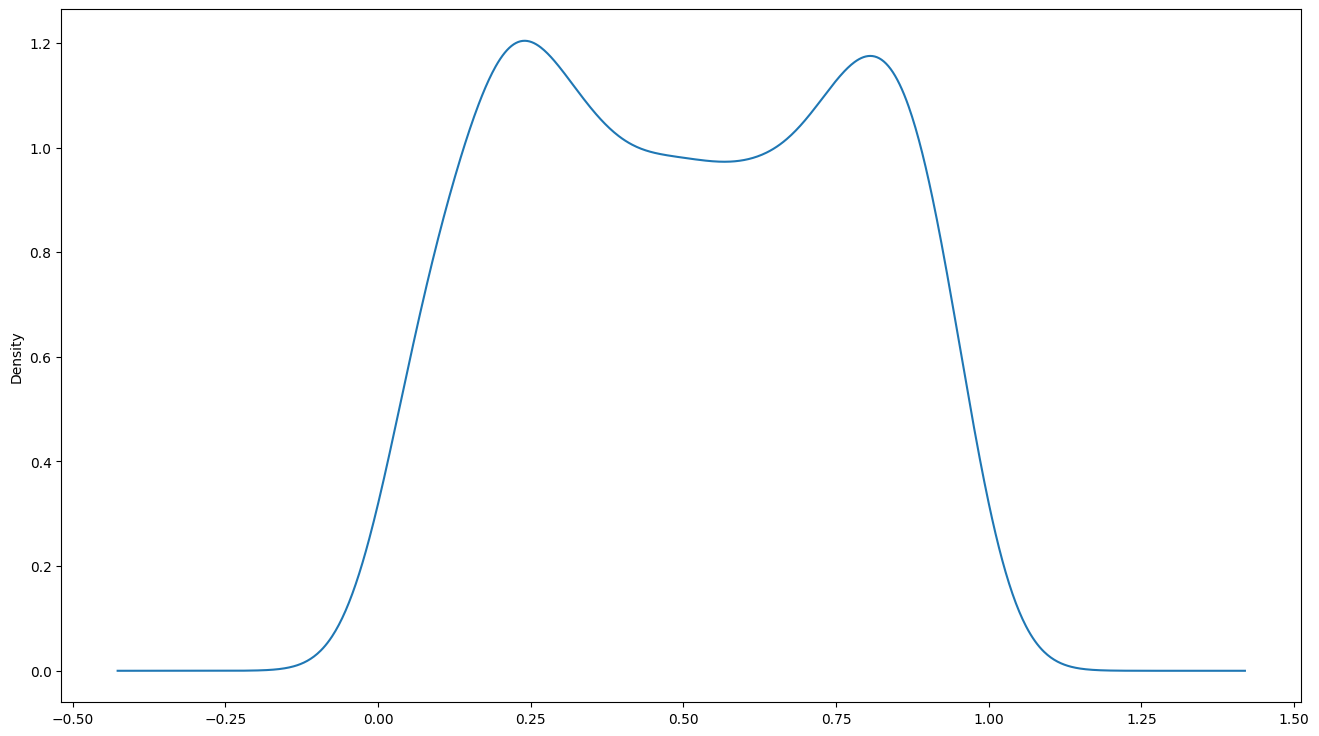

In [21]:
wsum_ensemble_wot['prediction'].plot.density(figsize=(16,9))

In [22]:
wsum_ensemble_wot.to_csv(os.path.join('ensemble/', 'wsum_ensemble_wot.csv'), index_label="id")

### Random Mix

In [23]:
rmix_ensemble = pd.read_csv(os.path.join(submit_path, 'bert_best.csv'), encoding='utf-8')

In [24]:
id_shuffle = rmix_ensemble.id.values.copy()

SEED = 42

random.seed(SEED)
random.shuffle(id_shuffle)

_size = int(len(id_shuffle) * 1/len(results))
results_list = ['bert', 'saint', 'lightgcn',  'tabnet']

In [25]:
rmix_ensemble['prediction'] = 0
for i in range(len(results)):
    for index in id_shuffle[i*_size:(i+1)*_size]:
        rmix_ensemble[rmix_ensemble.id == index] = results[results_list[i]][0][results[results_list[i]][0].id == index]

<AxesSubplot: ylabel='Density'>

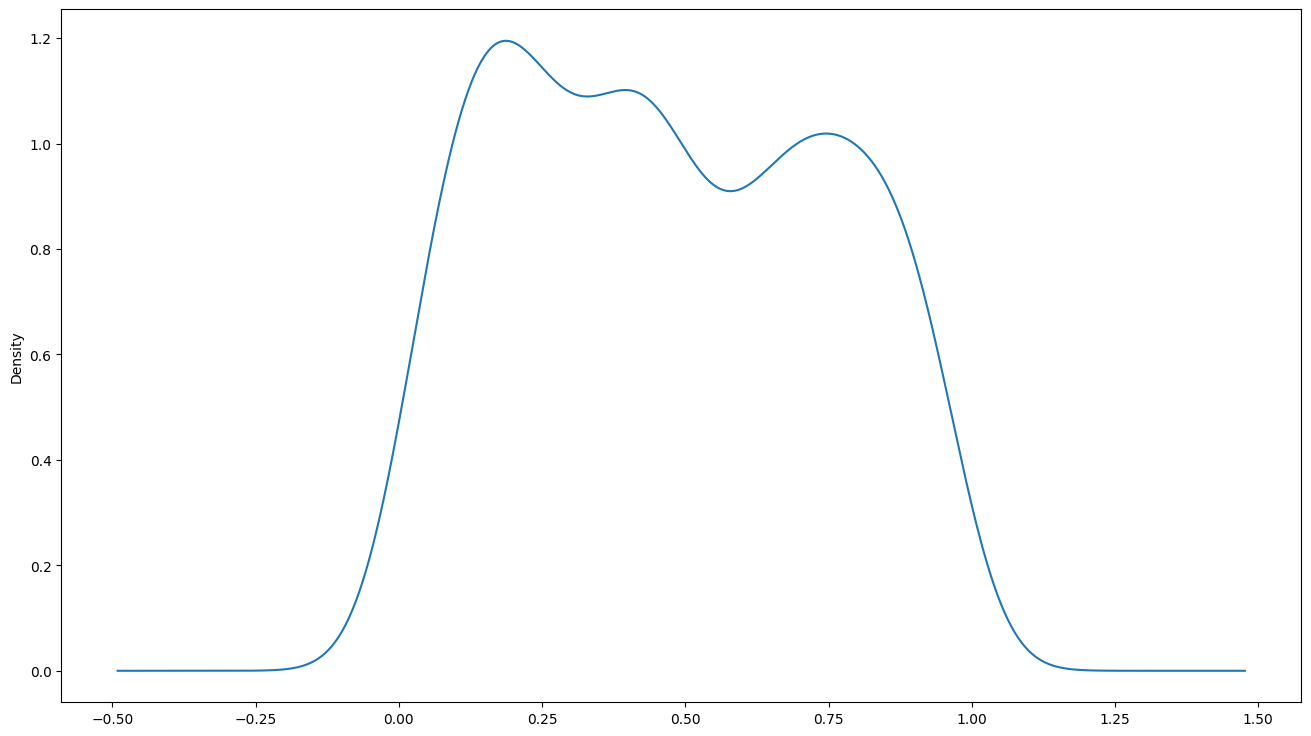

In [26]:
rmix_ensemble['prediction'].plot.density(figsize=(16,9))

In [27]:
rmix_ensemble.to_csv(os.path.join('ensemble/', 'rmix_ensemble.csv'), index_label="id")

### Density Weighted Sum

In [28]:
dwsum_ensemble = pd.read_csv(os.path.join(submit_path, 'bert_best.csv'), encoding='utf-8')

In [29]:
import scipy

# auc, acc에 자체 스케일링 기능이 있어 굳이 0~1사이로 맞추지 않아도 됨 => 그러나 시각화해서 비교하려면 맞춰야지~
dwsum_ensemble['prediction'] = 0
for r in tmp.columns.values[1:]:
    kernal = scipy.stats.gaussian_kde(tmp[r])
    m = max(tmp[r]*kernal(tmp[r]))
    dwsum_ensemble['prediction'] += tmp[r]*kernal(tmp[r]) / (m * (len(tmp.columns.values)-1))

<AxesSubplot: ylabel='Density'>

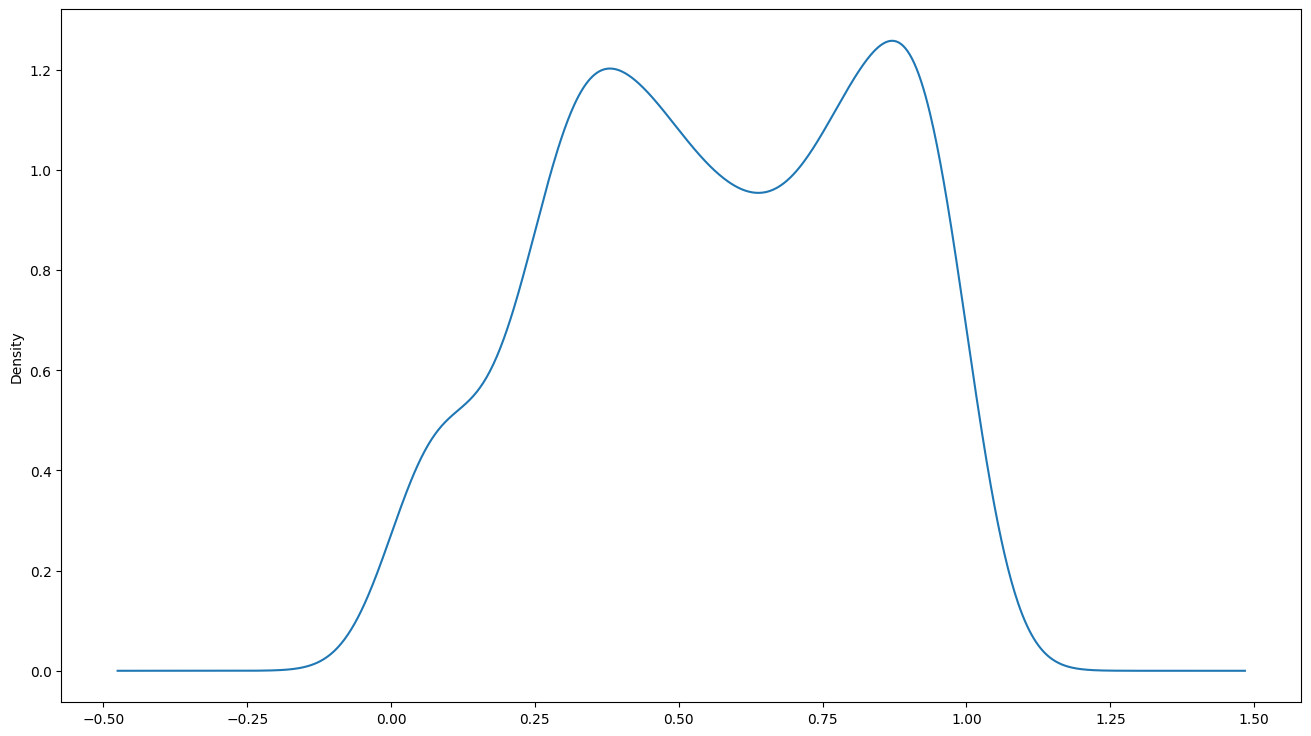

In [30]:
dwsum_ensemble['prediction'].plot.density(figsize=(16,9))

In [31]:
dwsum_ensemble.to_csv(os.path.join('ensemble/', 'dwsum_ensemble.csv'), index_label="id")

### Density Square Weighted Sum

In [32]:
dswsum_ensemble = pd.read_csv(os.path.join(submit_path, 'bert_best.csv'), encoding='utf-8')

In [33]:
import scipy

# auc, acc에 자체 스케일링 기능이 있어 굳이 0~1사이로 맞추지 않아도 됨 => 그러나 시각화해서 비교하려면 맞춰야지~
dswsum_ensemble['prediction'] = 0
for r in tmp.columns.values[1:]:
    kernal = scipy.stats.gaussian_kde(tmp[r])
    m = max(tmp[r]*np.square(kernal(tmp[r])))
    dswsum_ensemble['prediction'] += tmp[r]*np.square(kernal(tmp[r])) / (m * (len(tmp.columns.values)-1))

<AxesSubplot: ylabel='Density'>

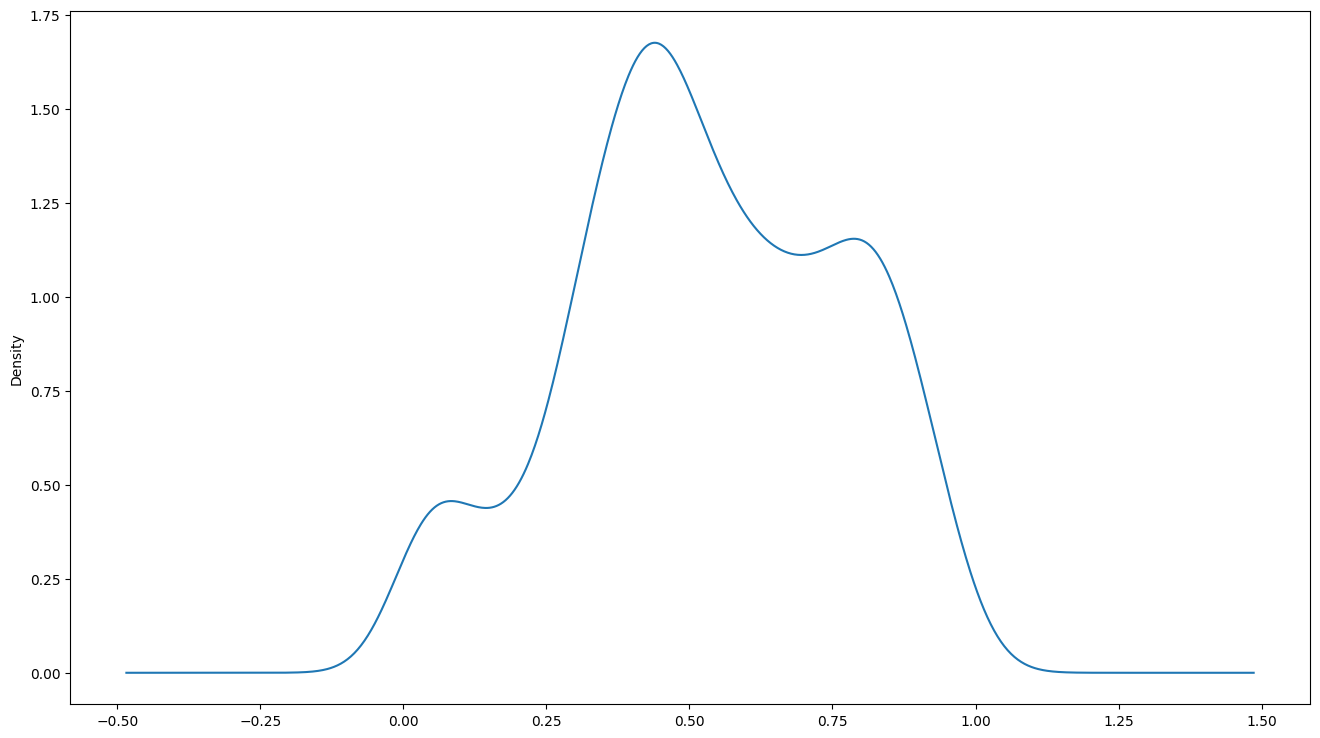

In [34]:
dswsum_ensemble['prediction'].plot.density(figsize=(16,9))

In [35]:
dswsum_ensemble.to_csv(os.path.join('ensemble/', 'dswsum_ensemble.csv'), index_label="id")

## Ensemble 비교

In [36]:
sum_ensemble.columns = ['id', 'sum-ensemble_0.8141']
wsum_ensemble.columns = ['id', 'wsum-ensemble_0.8148']
wsum_ensemble_wot.columns = ['id', 'wsum-ensemble-wot_0.8147']
rmix_ensemble.columns = ['id', 'rmix-ensemble_0.8042']
dwsum_ensemble.columns = ['id', 'dwsum-ensemble_']
dswsum_ensemble.columns = ['id', 'dswsum_ensemble_']

In [37]:
_tmp = pd.merge(sum_ensemble, wsum_ensemble, on='id')
_tmp = pd.merge(_tmp, wsum_ensemble_wot, on='id')
_tmp = pd.merge(_tmp, rmix_ensemble, on='id')
_tmp = pd.merge(_tmp, dwsum_ensemble, on='id')
_tmp = pd.merge(_tmp, dswsum_ensemble, on='id')

<AxesSubplot: ylabel='Density'>

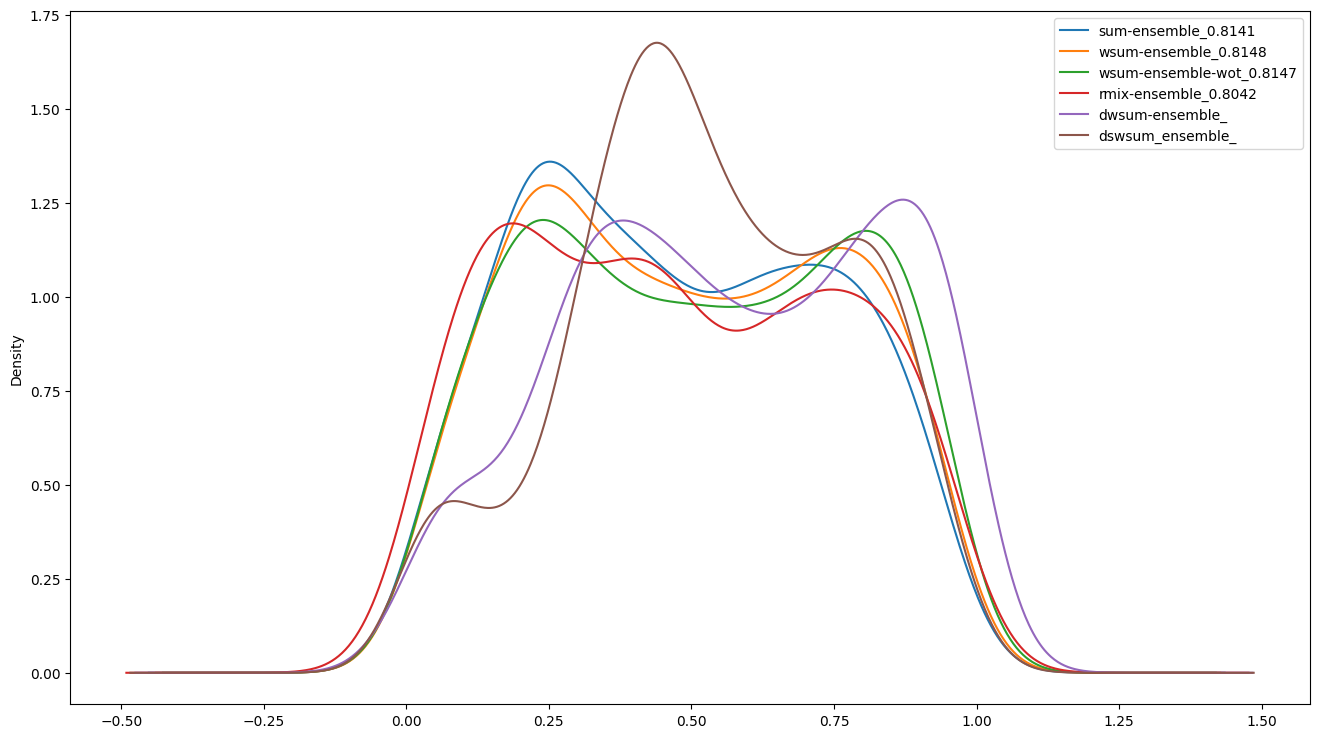

In [38]:
_tmp[_tmp.columns.values[1:]].plot.density(figsize=(16,9))